# Geometry and shape space - TP3 - Construction of atlases and connections to geometric data

<br>
<br>

## 1. Examples of diffeomorphic pairings: points, measures, varifolds

### a) Codes for LDDMM implementation

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [16, 10]

import torch
from torch.autograd import grad


# noyau gaussien (K(x,y)b)_i = sum_j exp(-|xi-yj|^2)bj
def GaussKernel(sigma):
    oos2 = 1/sigma**2
    def K(x,y,b):
        return torch.exp(-oos2*torch.sum((x[:,None,:]-y[None,:,:])**2,dim=2))@b
    return K

# solveur d'ODE
def RalstonIntegrator(nt=10):
    def f(ODESystem,x0,deltat=1.0):
        x = tuple(map(lambda x:x.clone(),x0))
        dt = deltat/nt
        for i in range(nt):
            xdot = ODESystem(*x)
            xi = tuple(map(lambda x,xdot:x+(2*dt/3)*xdot,x,xdot))
            xdoti = ODESystem(*xi)
            x = tuple(map(lambda x,xdot,xdoti:x+(.25*dt)*(xdot+3*xdoti),x,xdot,xdoti))
        return x
    return f

# définition du Hamiltonien H(p,q)
def Hamiltonian(K):
    def H(p,q):
        return .5*(p*K(q,q,p)).sum()
    return H

# système hamiltonien à résoudre pour le shooting
def HamiltonianSystem(K):
    H = Hamiltonian(K)
    def HS(p,q):
        Gp,Gq = grad(H(p,q),(p,q), create_graph=True)
        return -Gq,Gp
    return HS

# shooting = intégration du système hamiltonien
def Shooting(p0,q0,K,deltat=1.0,Integrator=RalstonIntegrator()):
    return Integrator(HamiltonianSystem(K),(p0,q0),deltat)

# intégration des équations de flot
def Flow(x0,p0,q0,K,deltat=1.0,Integrator=RalstonIntegrator()):
    # x0: contour points, p0,q0: output of the matching 
    HS = HamiltonianSystem(K)
    def FlowEq(x,p,q):
        return (K(x,q,p),)+HS(p,q)
    return Integrator(FlowEq,(x0,p0,q0),deltat)[0]

# définition de la fonctionnelle à minimiser
def LDDMMloss(q0,K,dataloss,gamma=0.):
    def loss(p0):
        p,q = Shooting(p0,q0,K)
        return gamma * Hamiltonian(K)(p0,q0) + dataloss(q)
    return loss



# méthode d'optimisation générique
def Optimize(loss,args,niter=5):
    optimizer = torch.optim.LBFGS(args)
    print('performing optimization...')
    for i in range(niter):
        print("iteration ",i+1,"/",niter)
        def closure():
            optimizer.zero_grad()
            L = loss(*args)
            L.backward()
            return L
        optimizer.step(closure)
    print("Done.")
    return args



# fonction d'affichage du résultat pour des données landmarks ou nuages de points
def PlotRes2D(z,pts=None):
    def plotfun(q0,p0,Kv):
        p,q = Shooting(p0,q0,Kv)
        q0np, qnp = q0.data.numpy(), q.data.numpy()
        q0np, qnp, znp = q0.data.numpy(), q.data.numpy(), z.data.numpy()
        plt.plot(znp[:,0],znp[:,1],'.');
        plt.plot(q0np[:,0],q0np[:,1],'+');
        plt.plot(qnp[:,0],qnp[:,1],'o');
        plt.axis('equal');
        ng = 50
        a = np.min(np.vstack((q0np[:,0],qnp[:,0])))
        b = np.max(np.vstack((q0np[:,0],qnp[:,0])))
        c = np.min(np.vstack((q0np[:,1],qnp[:,1])))
        d = np.max(np.vstack((q0np[:,1],qnp[:,1])))
        sz = 0.2
        lsp1 = np.linspace(a-sz*(b-a),b+sz*(b-a),ng,dtype=np.float32)
        lsp2 = np.linspace(c-sz*(d-c),d+sz*(d-c),ng,dtype=np.float32)
        X1, X2 = np.meshgrid(lsp1,lsp2)
        x = np.concatenate((X1.reshape(ng**2,1),X2.reshape(ng**2,1)),axis=1)
        phix = Flow(torch.from_numpy(x),p0,q0,Kv).detach().numpy()
        X1 = phix[:,0].reshape(ng,ng)
        X2 = phix[:,1].reshape(ng,ng)
        plt.plot(X1,X2,'k',linewidth=.25);
        plt.plot(X1.T,X2.T,'k',linewidth=.25); 
        n,d = q0.shape
        nt = 20
        Q = np.zeros((n,d,nt))
        for i in range(nt):
            t = i/(nt-1)
            Q[:,:,i] = Shooting(t*p0,q0,Kv)[1].data.numpy()
        plt.plot(Q[:,0,:].T,Q[:,1,:].T,'y');
        if type(pts)!=type(None):
            phipts = Flow(pts,p0,q0,Kv).data
            plt.plot(phipts.numpy()[:,0],phipts.numpy()[:,1],'.b',markersize=.1);
    return plotfun

# fonction d'affichage pour des données de type surface triangulée
def PlotResSurf(VS,FS,VT,FT):
    def plotfun(q0,p0,Kv):
        fig = plt.figure();
        plt.axis('off')
        plt.title('LDDMM matching example')  
        p,q = Shooting(p0,q0,Kv)
        q0np, qnp = q0.data.numpy(), q.data.numpy()
        FSnp,VTnp, FTnp = FS.data.numpy(),  VT.data.numpy(), FT.data.numpy()    
        ax = Axes3D(fig, auto_add_to_figure=False)
        ax.plot_trisurf(q0np[:,0],q0np[:,1],q0np[:,2],triangles=FSnp,alpha=.5)
        ax.plot_trisurf(qnp[:,0],qnp[:,1],qnp[:,2],triangles=FSnp,alpha=.5)
        ax.plot_trisurf(VTnp[:,0],VTnp[:,1],VTnp[:,2],triangles=FTnp,alpha=.5)
        fig.add_axes(ax)
    return plotfun

### b) Fonctions d'attache aux données

In [2]:
# fonction d'attache aux données pour des landmarks
def losslmk(z):
    def loss(q):
        return ((q-z)**2).sum()
    return loss

# fonction d'attache aux données pour des nuages de points via le modèle des mesures
def lossmeas(z,Kw):
    nz = z.shape[0]
    wz = torch.ones(nz,1)
    cst = (1/nz**2)*Kw(z,z,wz).sum()
    def loss(q):
        nq = q.shape[0]
        wq = torch.ones(nq,1)
        return cst + (1/nq**2)*Kw(q,q,wq).sum() + (-2/(nq*nz))*Kw(q,z,wz).sum()
    return loss


# noyau pour les varifolds (K(x,y,u,v)b)_i = sum_j exp(-|xi-yj|^2) <ui,vj>^2 bj
def GaussLinKernel(sigma,lib="keops"):
    oos2 = 1/sigma**2
    def K(x,y,u,v,b):
        Kxy = torch.exp(-oos2*torch.sum((x[:,None,:]-y[None,:,:])**2,dim=2))
        Sxy = torch.sum(u[:,None,:]*v[None,:,:],dim=2)**2
        return (Kxy*Sxy)@b
    return K


# fonction d'attache aux données pour les surfaces triangulées, modèle des varifolds
# VT: coordonnées des points de la surface cible
# FS,FT : indices des triangles des surfaces source et cible
# K : noyau varifold
def lossVarifoldSurf(FS,VT,FT,K):
    def CompCLNn(F,V):
        V0, V1, V2 = V.index_select(0,F[:,0]), V.index_select(0,F[:,1]), V.index_select(0,F[:,2])
        C, N = .5*(V0+V1+V2), .5*torch.cross(V1-V0,V2-V0)
        L = (N**2).sum(dim=1)[:,None].sqrt()
        return C,L,N/L
    CT,LT,NTn = CompCLNn(FT,VT)
    cst = (LT*K(CT,CT,NTn,NTn,LT)).sum()
    def loss(VS):
        CS,LS,NSn = CompCLNn(FS,VS)
        return cst + (LS*K(CS,CS,NSn,NSn,LS)).sum() - 2*(LS*K(CS,CT,NSn,NTn,LT)).sum()
    return loss


# fonction similaire pour les courbes
def lossVarifoldCurve(FS, VT, FT, K):
    def get_center_length_tangents(F, V):
        V0, V1 = V.index_select(0, F[:, 0]), V.index_select(0, F[:, 1])
        centers, tangents = .5*(V0+V1), V1-V0
        length = (tangents**2).sum(dim=1)[:, None].sqrt()
        return centers, length, tangents / length
    CT, LT, TTn = get_center_length_tangents(FT, VT)
    cst = (LT * K(CT, CT, TTn, TTn, LT)).sum()
    def loss(VS):
        CS, LS, TSn = get_center_length_tangents(FS, VS)
        return cst + (LS * K(CS, CS, TSn, TSn, LS)).sum() - 2 * (LS * K(CS, CT, TSn, TTn, LT)).sum()
    return loss

### Exemple de matching de landmarks - données "poissons" du TP 2

In [6]:
def load(fname='store.pckl'):
    # chargement d'un fichier pickle
    import pickle
    f = open(fname, 'rb')
    obj = pickle.load(f)
    f.close()
    return obj

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


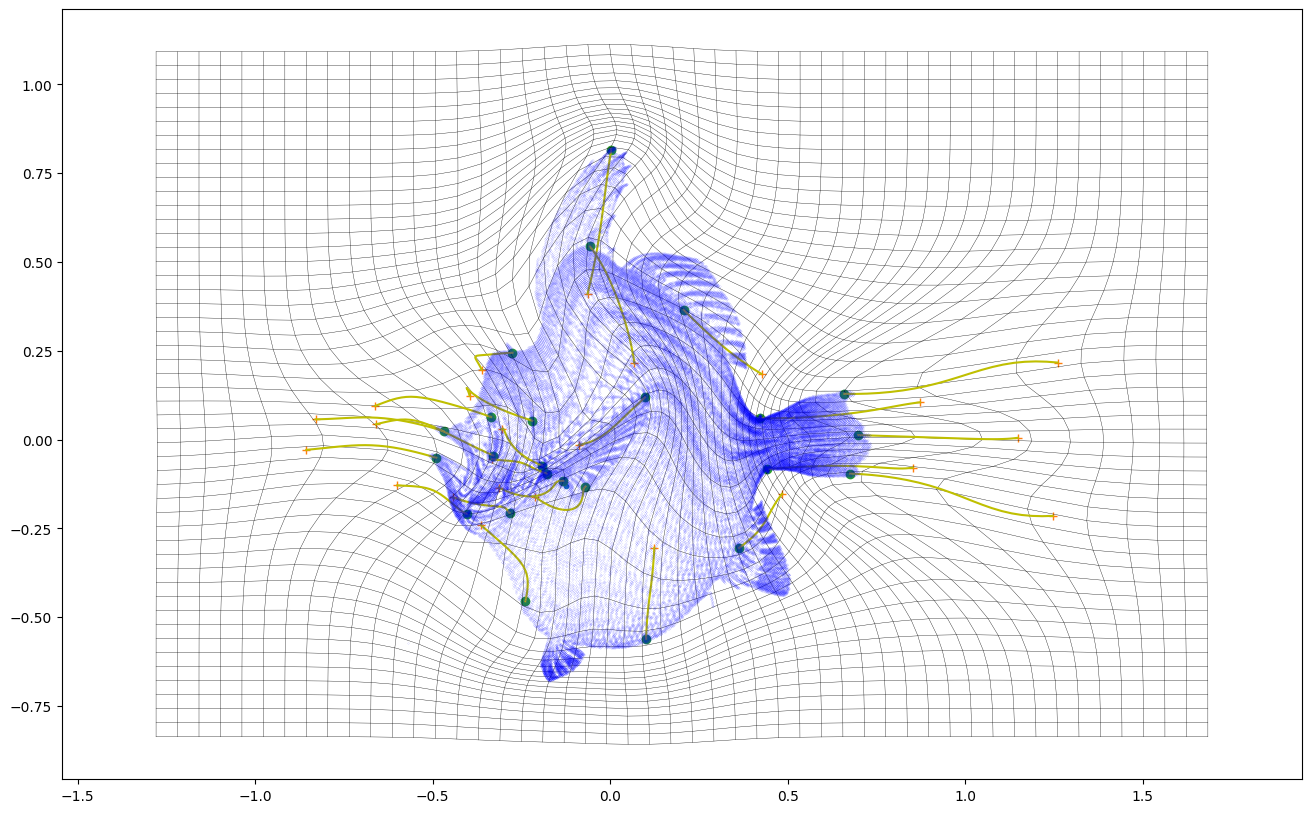

In [8]:
# on charge les données
pts1, pts2, lmk1, lmk2 = load('fish.pckl')
pts1 = torch.from_numpy(pts1).float()
pts2 = torch.from_numpy(pts2).float()
lmk1 = torch.from_numpy(lmk1).float()
lmk2 = torch.from_numpy(lmk2).float()
# définition des points q0 = landmarks du premier poisson
q0 = lmk1.clone().detach().requires_grad_(True)

# définition du noyau Kv
Kv = GaussKernel(sigma=.25)

# terme d'attache aux données
Dataloss = losslmk(lmk2)

# fonction globale à minimiser
loss = LDDMMloss(q0,Kv,Dataloss)

# initialisation des vecteurs moments p0
p0 = torch.zeros(q0.shape, requires_grad=True)

# optimisation de p0
p0, = Optimize(loss,[p0])

# affichage du résultat
plotfun = PlotRes2D(lmk2,pts1)
plotfun(q0,p0,Kv)
plt.show()

### Exemple de matching de mesures

### Example of measurement matching

C:\Users\82707\AppData\Local\Temp\ipykernel_20424\2037933030.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  VS, _, VT, _ = torch.load('curves.pt')


performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


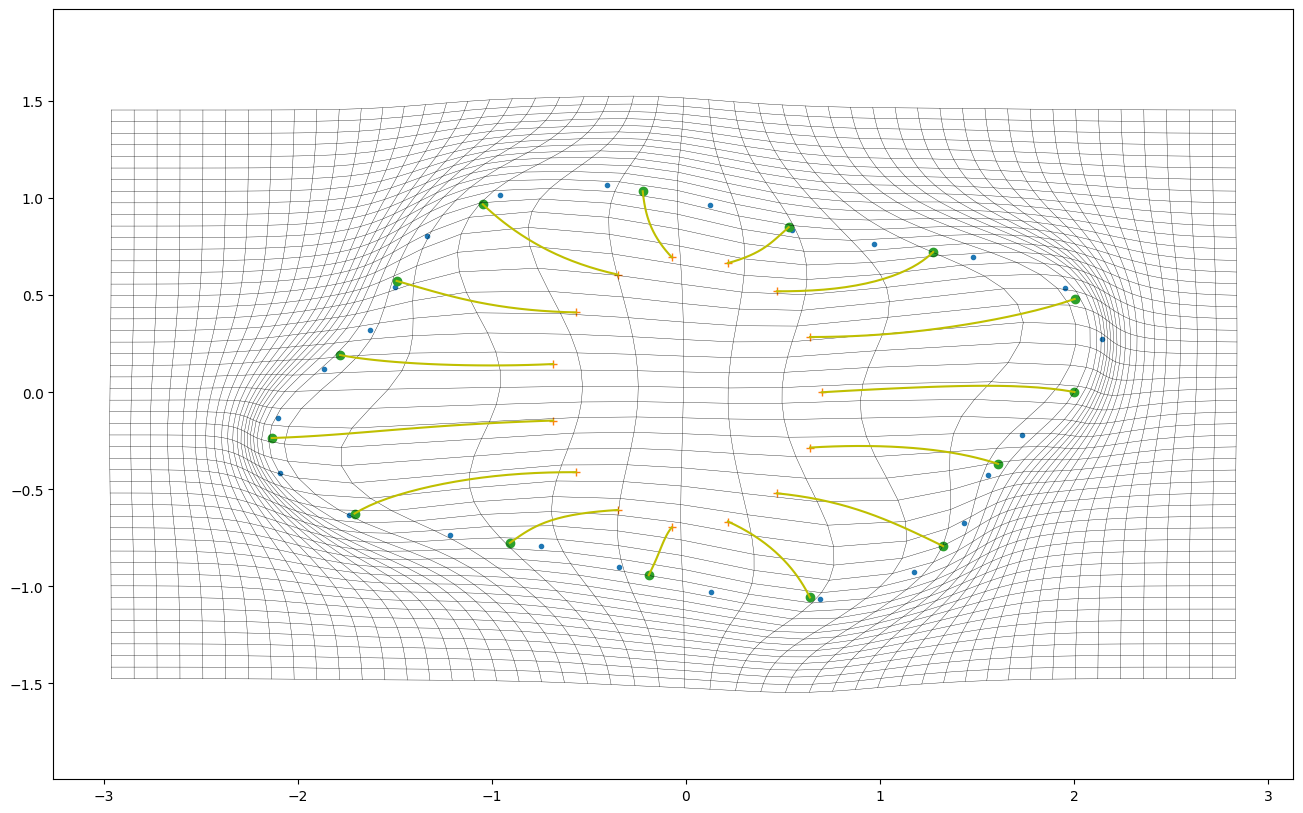

In [18]:
# exemple synthétique pour le modèle de mesures
VS, _, VT, _ = torch.load('curves.pt')
VS.requires_grad = True
q0 = VS
Kv = GaussKernel(sigma=.5)
Dataloss = lossmeas(VT,GaussKernel(sigma=.5))
loss = LDDMMloss(q0,Kv,Dataloss)
p0 = torch.zeros(q0.shape, requires_grad=True)
p0, = Optimize(loss,[p0])

# affichage du résultat
plotfun = PlotRes2D(VT)
plotfun(q0,p0,Kv)
plt.show()

### Exemple de matching de surfaces - modèle des varifolds

### Example of surface matching - varifold model

C:\Users\82707\AppData\Local\Temp\ipykernel_20424\616951643.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  VS,FS,VT,FT = torch.load('hippos_reduc_reduc.pt')
C:\Users\82

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


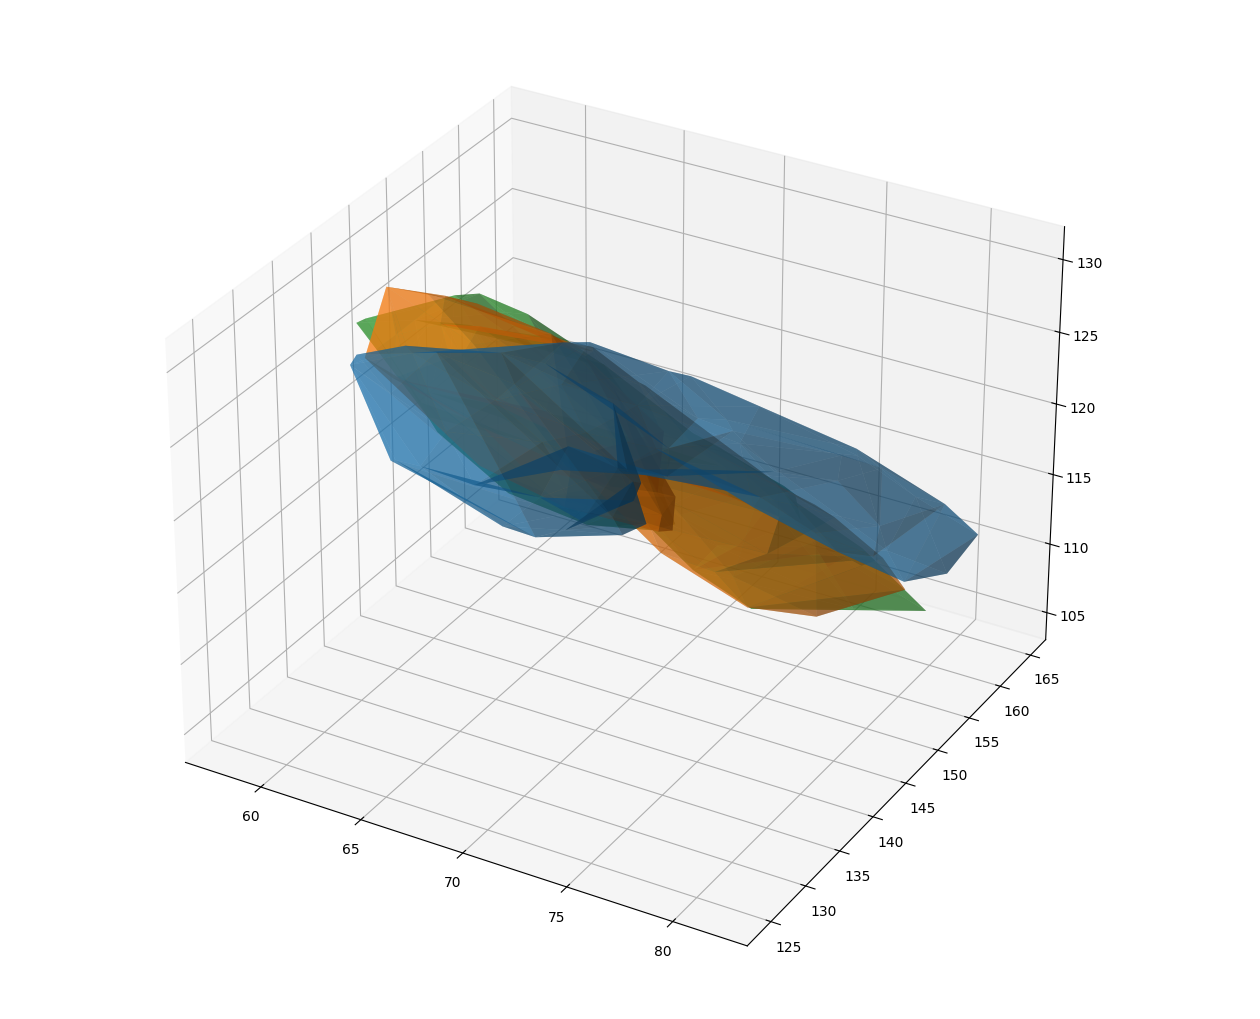

In [10]:
VS,FS,VT,FT = torch.load('hippos_reduc_reduc.pt')
# s: source, t: target, vs: vertices, f: faces
# downsample to a manageable amount of traingles
VS.requires_grad = True
q0 = VS
Kv = GaussKernel(sigma=20)   # parameter: typical length scale of data (adjust as required)
Dataloss = lossVarifoldSurf(FS,VT,FT,GaussLinKernel(sigma=20))
loss = LDDMMloss(q0,Kv,Dataloss)
p0 = torch.zeros(q0.shape, requires_grad=True)
p0, = Optimize(loss,[p0])

# affichage du résultat
plotfun = PlotResSurf(VS,FS,VT,FT)
plotfun(q0,p0,Kv)
plt.show()

<br>
<br>

## 2. Atlas construction

Here we will see how to create an atlas construction model for the study of a population of shapes. In other words, from the data of $N$ similar shapes $x^k$, we seek to jointly obtain an average shape (the prototype) $\bar x$ and optimal $\phi^k$ deformations between $\bar x$ and $x^k$. The final data from the $N$ $\phi^k$ transformations then allows a statistical study to be carried out on the population.

We will assume that the shapes considered are configurable by sets of points: $\x^k=(x_i^k)_{1\leq i\leq n_k}\in(\R^d)^{n_k}$.

### a) First model: deformations parameterized by the points of the prototype

$\newcommand{\x}{{\bf x}}$
$\newcommand{\p}{\boldsymbol{p}}$
$\newcommand{\q}{\boldsymbol{q}}$
$\newcommand{\id}{{\mathrm{id}}}$
$\def\scal#1#2{\left\langle #1\mathbin{,}#2\right\rangle}$
$\newcommand{\KV}{K_V}$
$\newcommand{\z}{\boldsymbol{z}}$

We first consider the following functional:
$$\tilde J(\{\phi^k\}_{1\leq k\leq N},\bar\x)=\sum_{k=1}^N\left\{\gamma d_V(\id,\phi^k)^2+A_k(\phi^k(\bar \x))\right\},$$
where $V$ is a Hilbert space of vector fields,
$$d_V(\id,\phi^k)^2=\inf\left\{\int_0^1\|v(t,\cdot)\|_V^2\;dt,\;\;\phi^v(1,\cdot)=\phi^k\right\}$$
with $\phi^v$ the flow of fields $v(t,\cdot)$,
$\gamma>0$ a parameter,
and $A_k$ is the data attachment functional for the $\x^k$ form, while $\bar x$ is the “shape” (set of points here) prototype to optimize. The number of $n$ points of $\bar x$ is fixed.
For such a problem, as for the simple matching problem, the optimal $\phi^k$ transformations are parameterized by $p_i(0)^k$ vectors (called initial moments) attached to the $\bar x_i$ points, and the problem amounts to minimizing
$$J(\{\p^k(0)\}_{1\leq k\leq N},\bar\x)=\sum_{k=1}^N\left\{\gamma\scal{\p^k(0)}{\KV(\bar\x,\bar\x)\p^k(0)}+A_k(\q^k(1))\right\},$$
where $\p^k(t),\q^k(t)$ follow the geodesic equations (see 2nd TP), with $\q^k(0)=\bar\x$.

<br>

__Question 1__: We will work with 2D curve type data and use the data attachment with the varifold method: $A_k(\z)=\|[\z]-[\x^k]\|_{W'}^2$, where $[\z]$ designates the varifold associated with the curve sampled by the points of $\z$, and $\|\cdot\|_{W'}$ the dual Hilbert norm on the space of varifolds. (N.B. It is not necessary to understand the varifold model to do the following; you can use this data attachment directly)

Adapt the diffeomorphic matching example code to obtain this atlas construction model.

In [11]:
# Question 1

def AtlasLDDMMloss(K,dataloss,gamma=0):
    # fonction similaire à LDDMMloss, pour la construction d'atlas
    # -> doit définir la fonction J(p^k,xbar) du TP
    # arguments : 
    #    K : noyau KV du modèle difféomorphique
    #    dataloss : liste ou t-uple de fonctions d'attache aux données
    #    gamma : paramètre gamma de la fonction J
    # sortie :
    #    loss : fonction définissant J et pouvant être appelée sous la forme
    #           loss(p^1,p^2,...,p^N,xbar)
    def loss(*args):
        p0 = args[:-1]
        xbar = args[-1]
        N = len(p0)
        L = 0
        for k in range(N):
            p,q = Shooting(p0[k],xbar,K)
            L += gamma * Hamiltonian(K)(p0[k],xbar) + dataloss[k](q)
        return L
    return loss

__Question 2__: The file
${\it synth\_20.pt}$ contains a ${\sf x}$ list of $20$ configurations of $n=44$ points in the plane. View these configurations.

In [17]:
len(x), len(x[0]), len(x[0][0])

(20, 44, 2)

C:\Users\82707\AppData\Local\Temp\ipykernel_20424\833107454.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load('synth_20.pt')


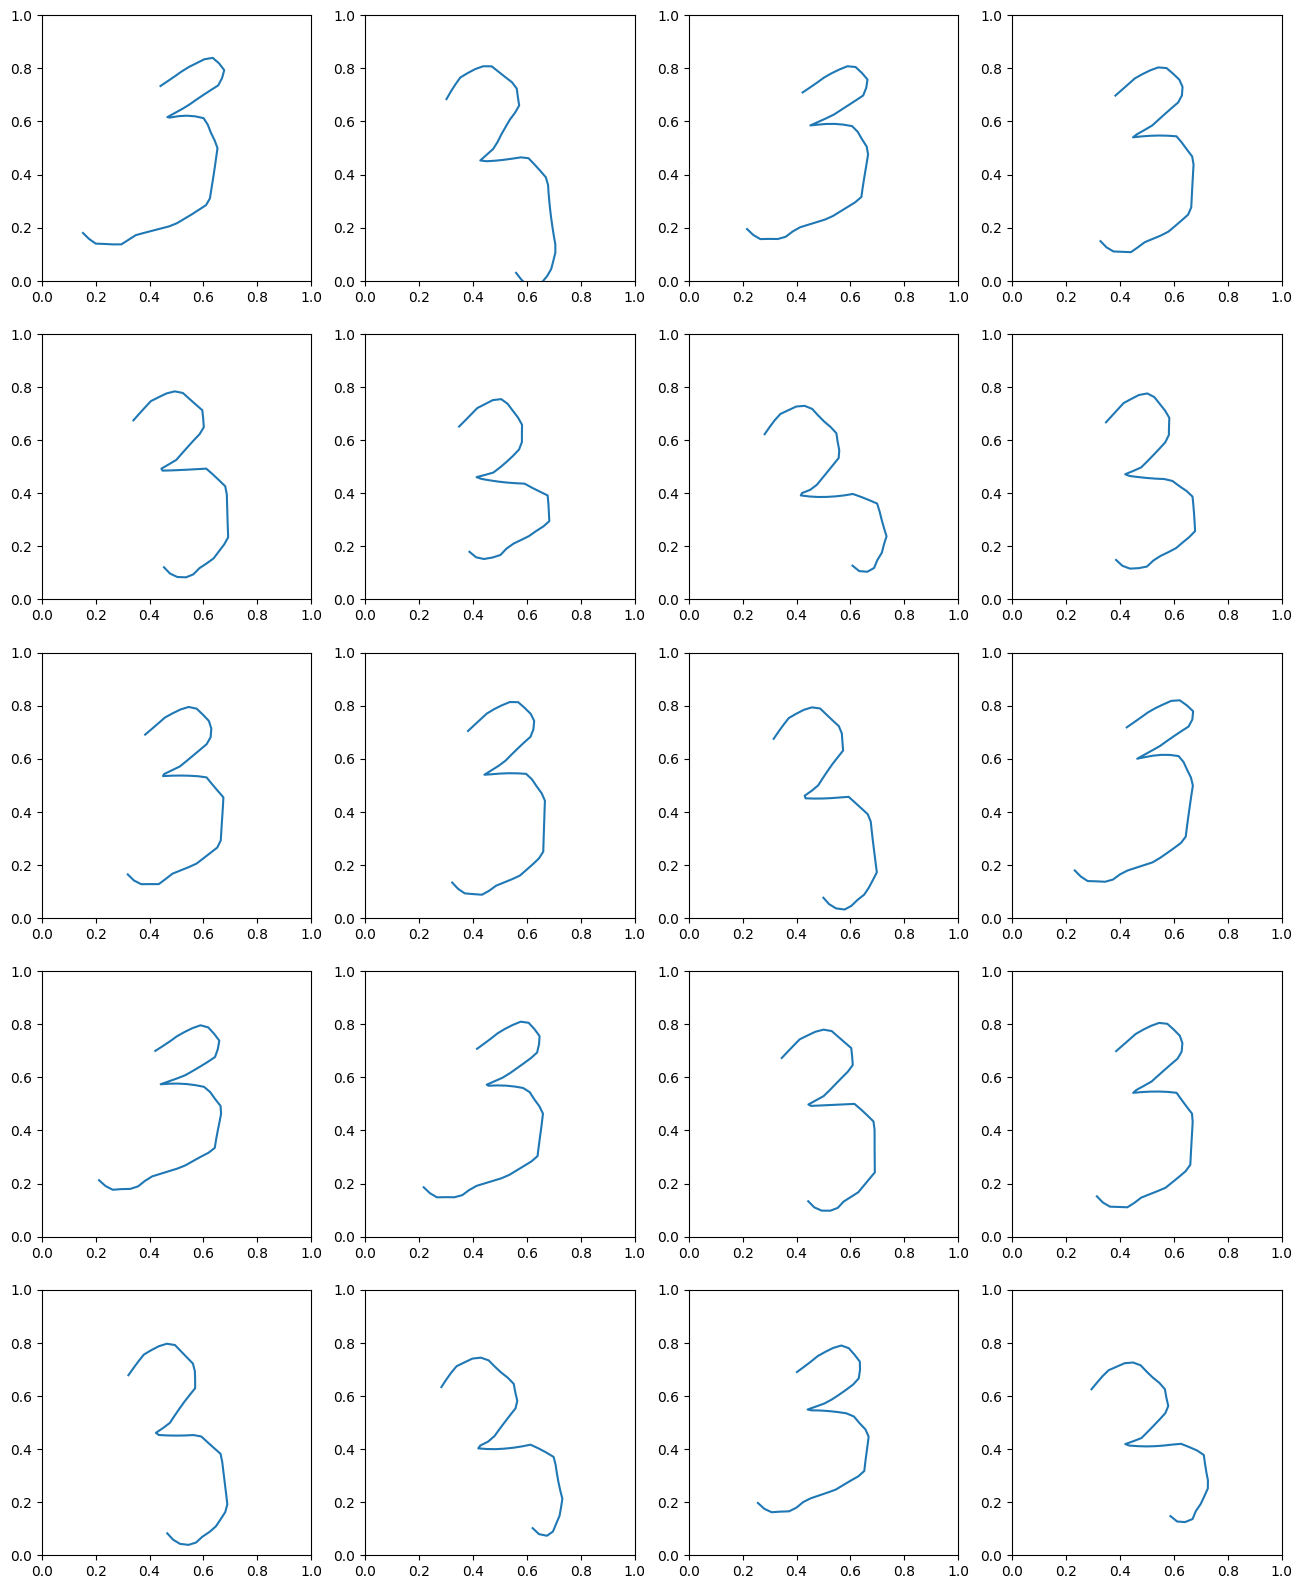

In [19]:
# Question 2 : affichage des données synth_20
plt.figure(figsize=(16,20))
x = torch.load('synth_20.pt')
N = len(x) # N=20
for k in range(N):
    plt.subplot(5,4,k+1)
    plt.plot(x[k][:,0],x[k][:,1])
    plt.axis([0,1,0,1])
plt.show()

__Question 3__ : Tester la méthode de construction d'atlas avec ces données, puis
afficher les positions des points $x_i^k$, $\bar x_i$ et $\phi^k(\bar x_i)$ après minimisation.

__Question 3__: Test the atlas construction method with these data, then
display the positions of points $x_i^k$, $\bar x_i$ and $\phi^k(\bar x_i)$ after minimization.

In [20]:
# définition des points xbar
xbar = x[0].clone().detach().requires_grad_(True)

nxbar = x[0].shape[0]
FS = torch.tensor(np.array([np.arange(nxbar-1),np.arange(1,nxbar)]).T).contiguous()

# définition du noyau Kv
Kv = GaussKernel(sigma=.25)

# définition du noyau Kw
Kw = GaussLinKernel(sigma=.25)

# terme d'attache aux données
Dataloss = []
for k in range(N):
    VT = x[k]
    nk = VT.shape[0]
    FT = torch.tensor(np.array([np.arange(nk-1),np.arange(1,nk)]).T).contiguous()
    loss = lossVarifoldCurve(FS, VT, FT, Kw)
    Dataloss.append(loss)

# fonction globale à minimiser
loss = AtlasLDDMMloss(Kv,Dataloss, gamma=0.1)

# initialisation des vecteurs moments p0
p0 = []
for k in range(N):
    p0.append(torch.zeros(x[0].shape, requires_grad=True))

# optimisation de p0 et xbar
res = Optimize(loss,[*p0,xbar])
p0 = res[:-1]
xbar = res[-1]

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


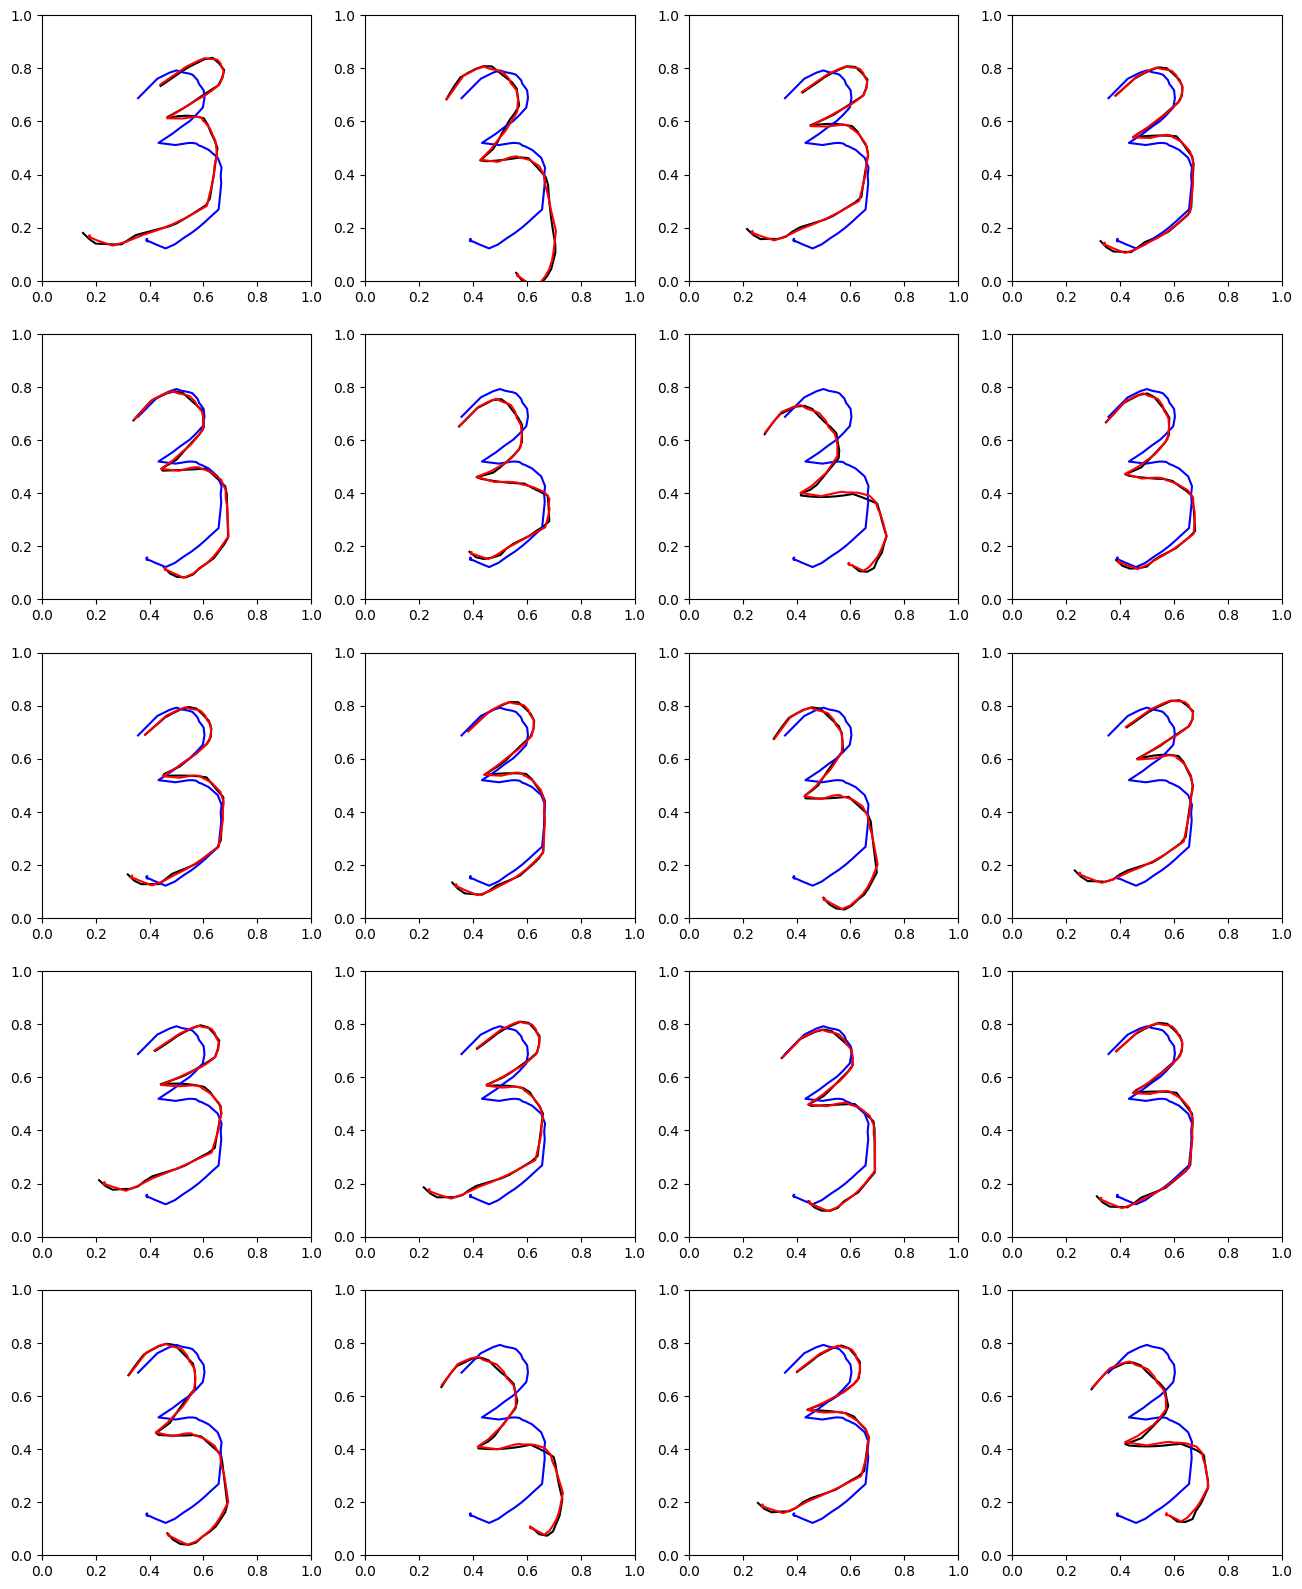

In [21]:
# affichage des résultats :

N = len(x) # N=20
plt.figure(figsize=(16,20))
for k in range(N):
    plt.subplot(5,4,k+1)
    plt.plot(x[k][:,0],x[k][:,1],"k")
    plt.plot(xbar.detach()[:,0],xbar.detach()[:,1],"b")
    p,q = Shooting(p0[k],xbar,Kv)
    plt.plot(q.detach()[:,0],q.detach()[:,1],"r")
    plt.axis([0,1,0,1])
plt.show()

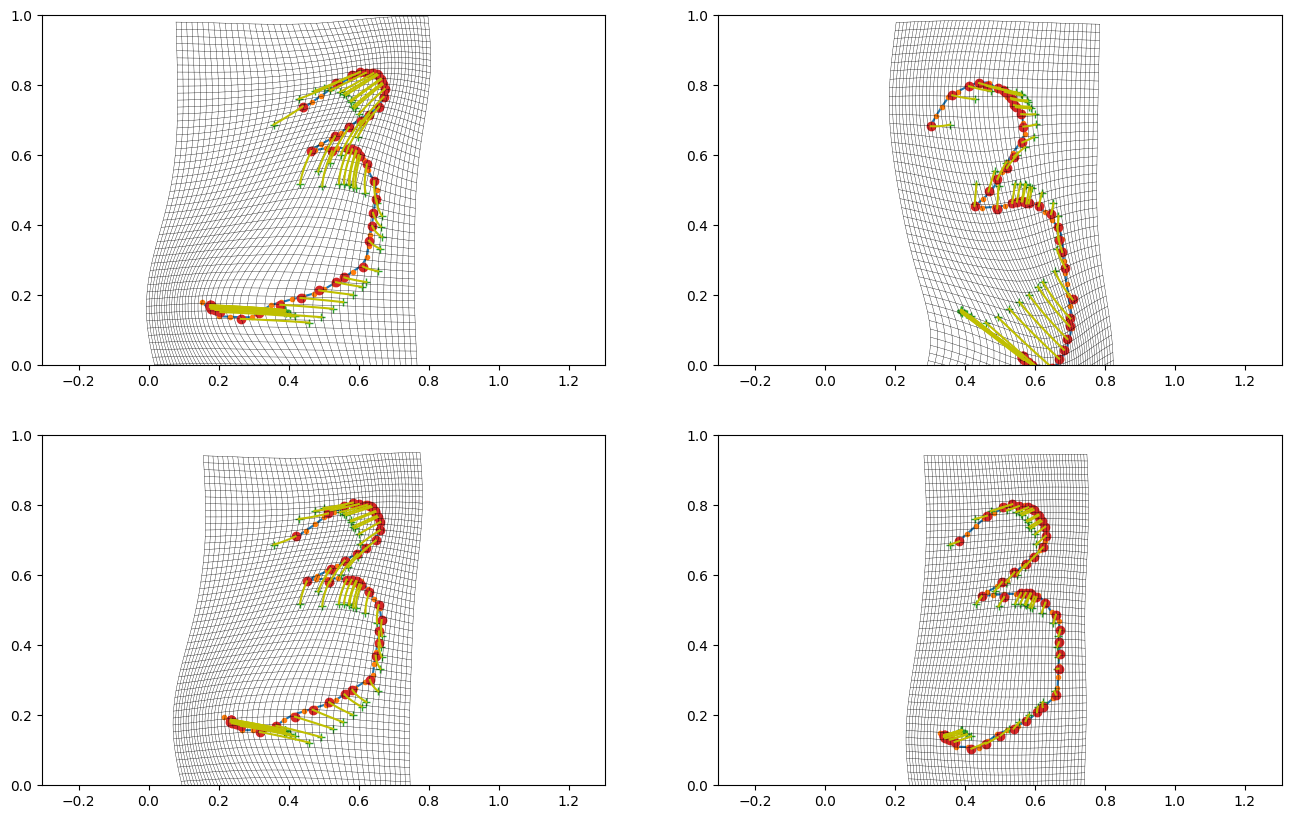

In [22]:
N = len(x) # N=20
for k in range(4):
    plt.subplot(2,2,k+1)
    plt.plot(x[k][:,0],x[k][:,1])
    plotfun = PlotRes2D(x[k])
    plotfun(xbar,p0[k],Kv)
    plt.axis([0,1,0,1])
plt.show()

__Question 4__ : A partir des vecteurs $\p^k(0)$, réaliser une Analyse en Composantes Principales (utiliser la fonction {\sf PCA} fournie) afin d'extraire les directions principales de déformation de la population. Afficher les formes correspondant à la moyenne et aux deux premières directions principales de déformation.

__Question 4__: From the $\p^k(0)$ vectors, carry out a Principal Component Analysis (use the {\sf PCA} function provided) in order to extract the main directions of deformation of the population. Show the shapes corresponding to the average and the first two principal directions of deformation.

In [23]:
# Question 4

from numpy import mean,cov,cumsum,dot,linalg,size,flipud,argsort

def PCA(X,numpc=0):
    # perform Principal Component Analysis of data matrix X
    # computing eigenvalues and eigenvectors of covariance matrix
    M = (X-mean(X.T,axis=1)).T # subtract the mean (along columns)
    [latent,coeff] = linalg.eig(cov(M))
    p = size(coeff,axis=1)
    idx = argsort(latent) # sorting the eigenvalues
    idx = idx[::-1]       # in ascending order
    # sorting eigenvectors according to the sorted eigenvalues
    coeff = coeff[:,idx]
    latent = latent[idx] # sorting eigenvalues
    if numpc < p and numpc >= 0:
        coeff = coeff[:,range(numpc)] # cutting some PCs if needed
    score = dot(coeff.T,M) # projection of the data in the new space
    return coeff,score,latent

In [24]:
n, d = p0[0].shape
N = len(p0)
X = np.zeros((N,n*d))
for k in range(N):
    X[k,:] = p0[k].detach().flatten()

In [25]:
coeff,score,latent = PCA(X,numpc=N)
coeff = np.real(coeff)

__Question 5__ : Calculer les $C(i,k)$ pour $1\leq i\leq N$ et $1\leq k\leq 3$ correspondant aux coordonnées des données projetées sur les trois premiers axes principaux, puis visualiser la population de formes dans ces coordonnées projetées.

__Question 5__: Calculate the $C(i,k)$ for $1\leq i\leq N$ and $1\leq k\leq 3$ corresponding to the coordinates of the data projected onto the first three principal axes, then visualize the population of shapes in these projected coordinates.

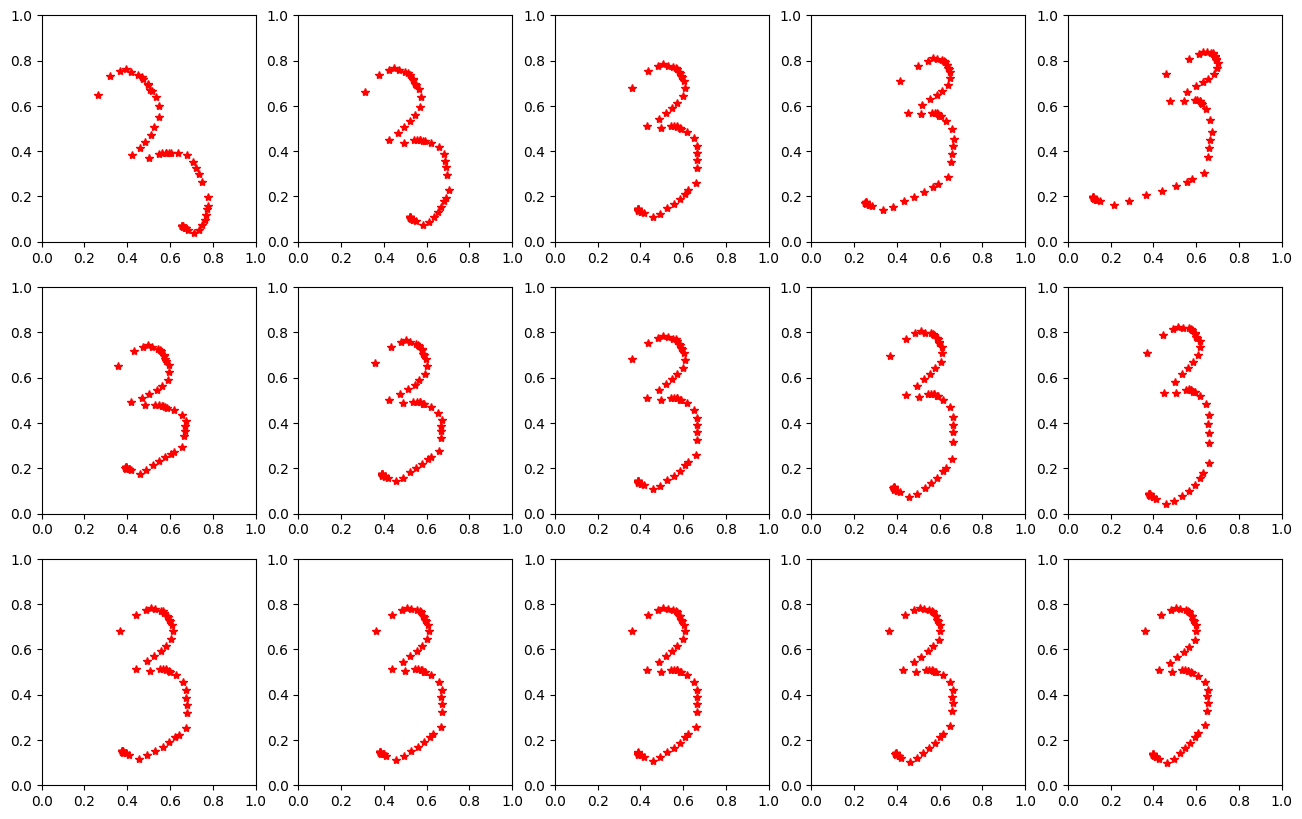

In [26]:
ncomp, ndisp = 3, 5
p0_bar = mean(X,axis=0)
k = 1
for pca_index in range(ncomp):
    sigma_pca = np.sqrt(np.real(latent[pca_index]))
    for alpha in np.linspace(-2*sigma_pca, 2*sigma_pca, ndisp):
        p0_mode = p0_bar + alpha * coeff[:,pca_index]
        p0_mode = torch.tensor(p0_mode.reshape(n,d).astype("float32"), requires_grad=True)
        p,q = Shooting(p0_mode,xbar,Kv)
        plt.subplot(ncomp,ndisp,k)        
        plt.plot(q.detach()[:,0],q.detach()[:,1],"*r")
        plt.axis([0,1,0,1])
        k += 1
plt.show()

### b) Deuxième modèle : dissociation des points de contrôle et du prototype

$\newcommand{\bcc}{{\bf c}}$
A présent on introduit des variables supplémentaires $(c_i)_{1\leq i\leq n_c}$ 
correspondant aux points de contrôle des déformations $\phi^k$, supposées dissociées des points du prototype. Les déformations $\phi^k$ sont alors paramétrées par ces points et les vecteurs $(p^k_i(0))_{1\leq i\leq n_c}$:
et le problème consiste alors à minimiser
$$J(\{\p^k(0)\}_{1\leq k\leq N},\bar\x,\bcc)=\sum_{k=1}^N\left\{\gamma\scal{\p^k(0)}{\KV(\bcc,\bcc)\p^k(0)}+A_k(\phi^k(\bar\x)\right\}.$$

__Question 6__ : Ecrire les fonctions permettant de calculer la fonctionnelle.
Faire des essais avec les données précédentes, avec par exemple $n_c=3$. Afficher la forme prototype optimale ainsi que les positions des points de contrôle $c_i$.

### b) Second model: dissociation of control points and the prototype

$\newcommand{\bcc}{{\bf c}}$
Now we introduce additional variables $(c_i)_{1\leq i\leq n_c}$
corresponding to the $\phi^k$ deformation control points, supposed to be dissociated from the points of the prototype. The $\phi^k$ deformations are then parameterized by these points and the $(p^k_i(0))_{1\leq i\leq n_c}$ vectors:
and the problem then consists of minimizing
$$J(\{\p^k(0)\}_{1\leq k\leq N},\bar\x,\bcc)=\sum_{k=1}^N\left\{\gamma\scal{\p^k(0)}{\KV(\bcc,\bcc)\p^k(0)}+A_k(\phi^k(\bar\x)\right\}.$$

__Question 6__: Write the functions allowing you to calculate the functional.
Do some tests with the previous data, for example with $n_c=3$. Show the optimal prototype shape as well as the positions of the $c_i$ control points.

In [27]:
def AtlasLDDMMloss2(K,dataloss,gamma=0):
    # fonction similaire à LDDMMloss, pour la construction d'atlas
    # -> doit définir la fonction J(p^k,xbar) du TP
    # arguments : 
    #    K : noyau KV du modèle difféomorphique
    #    dataloss : liste ou t-uple de fonctions d'attache aux données
    #    gamma : paramètre gamma de la fonction J
    # sortie :
    #    loss : fonction définissant J et pouvant être appelée sous la forme
    #           loss(p^1,p^2,...,p^N,xbar)
    def loss(*args):
        p0 = args[:-2]
        xbar = args[-2]
        c = args[-1]
        N = len(p0)
        L = 0
        for k in range(N):
            xbar1 = Flow(xbar,p0[k],c,K)
            L += gamma * Hamiltonian(K)(p0[k],c) + dataloss[k](xbar1)
        return L
    return loss

In [28]:
# définition des points xbar
xbar = x[0].clone().detach().requires_grad_(True)

nxbar = x[0].shape[0]
FS = torch.tensor(np.array([np.arange(nxbar-1),np.arange(1,nxbar)]).T).contiguous()

# définition du noyau Kv
Kv = GaussKernel(sigma=.25)

# définition du noyau Kw
Kw = GaussLinKernel(sigma=.25)

# terme d'attache aux données
Dataloss = []
for k in range(N):
    VT = x[k]
    nk = VT.shape[0]
    FT = torch.tensor(np.array([np.arange(nk-1),np.arange(1,nk)]).T).contiguous()
    loss = lossVarifoldCurve(FS, VT, FT, Kw)
    Dataloss.append(loss)
    
# fonction globale à minimiser
loss = AtlasLDDMMloss2(Kv,Dataloss, gamma=0.1)

nc = 7

# initialisation des vecteurs moments p0
p0 = []
for k in range(N):
    p0.append(torch.zeros(nc, 2, requires_grad=True))

# initialisation des points de controle c
c = torch.rand(nc,2, requires_grad=True)
    
# optimisation de p0 et xbar
res = Optimize(loss,[*p0,xbar,c],niter=10)
p0 = res[:-2]
xbar = res[-2]
c = res[-1]

performing optimization...
iteration  1 / 10
iteration  2 / 10
iteration  3 / 10
iteration  4 / 10
iteration  5 / 10
iteration  6 / 10
iteration  7 / 10
iteration  8 / 10
iteration  9 / 10
iteration  10 / 10
Done.


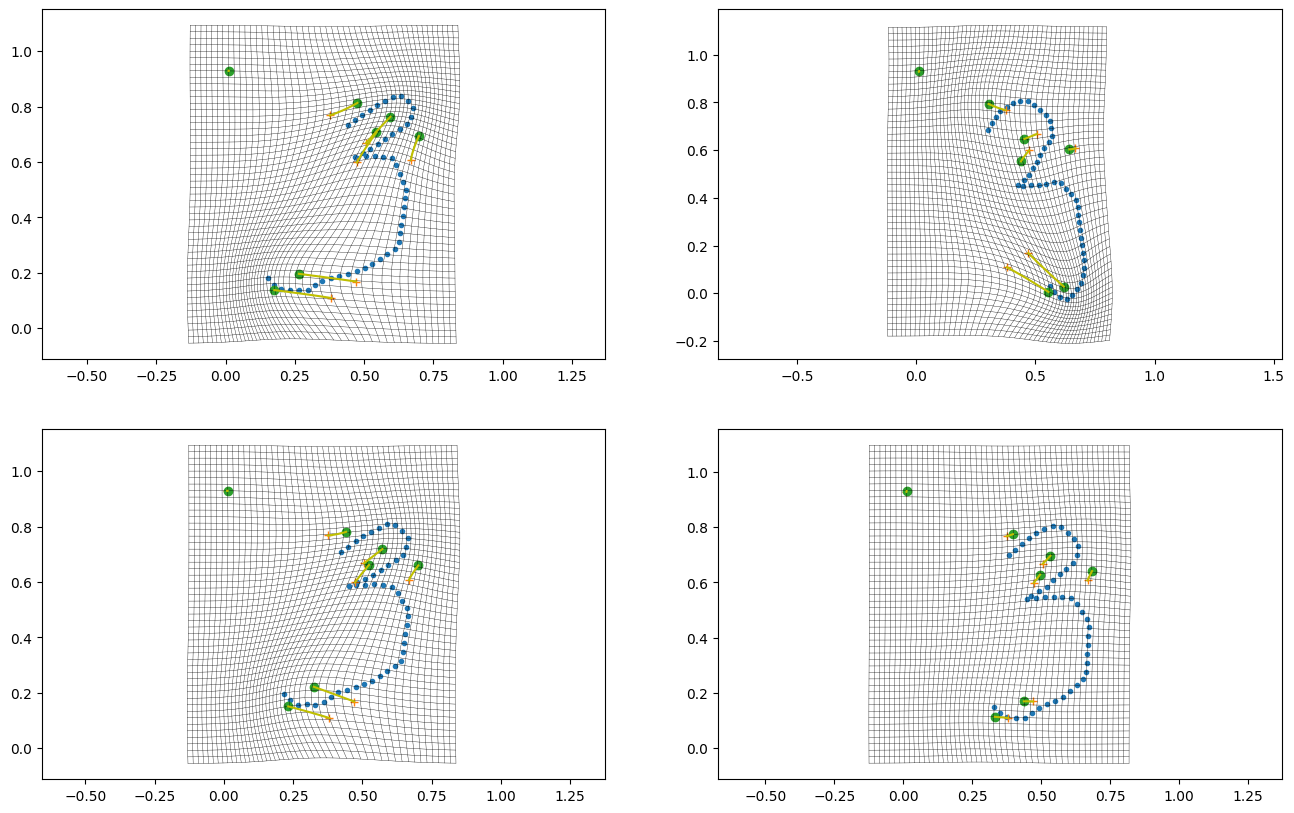

In [29]:
N = len(x) # N=20
for k in range(4):
    plt.subplot(2,2,k+1)
    #plt.plot(xbar.detach()[:,0],xbar.detach()[:,1],"*b")
    #plt.plot(x[k][:,0],x[k][:,1],"*k")
    plotfun = PlotRes2D(x[k])
    plotfun(c,p0[k],Kv)
    plt.axis("equal")
plt.show()

## 2. Données réelles - attache aux données de type mesures

Pour terminer nous allons réaliser une étude avec des données de type nuages de points non ordonnés. Il faut alors remplacer les fonctionnelles d'attache aux données $A_k$ par des fonctionnelles appropriées afin de quantifier la similarité entre deux nuages de points. Nous allons utiliser directement - sans l'étudier - le modèle des mesures qui définit une distance entre masses de Dirac pondérées.

__Question 7__ : Recommencer l'étude (construction d'atlas et ACP) avec les données du fichier `trois.pt` (obtenues à partir d'images binaires de chiffres 3 manuscrits), en utilisant la fonction `lossmeas` fournie pour calculer les nouvelles fonctionnelles $A_k$. 

N.B. Pour les paramètres on pourra choisir $\sigma_V=0.25$, $\sigma_W=0.1$, $\gamma=0.1$.

## 2. Real data - attaches to measurement type data

Finally, we will carry out a study with unordered point cloud data. It is then necessary to replace the functionals attached to the $A_k$ data by appropriate functionals in order to quantify the similarity between two clouds of points. We will use directly - without studying it - the measurement model which defines a distance between weighted Dirac masses.

__Question 7__: Start the study again (atlas construction and PCA) with the data from the file `trois.pt` (obtained from binary images of handwritten digits 3), using the function ` lossmeas` provided to calculate the new $A_k$ functionals.

N.B. For the parameters we can choose $\sigma_V=0.25$, $\sigma_W=0.1$, $\gamma=0.1$.

C:\Users\82707\AppData\Local\Temp\ipykernel_20424\1072892504.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load('trois.pt')


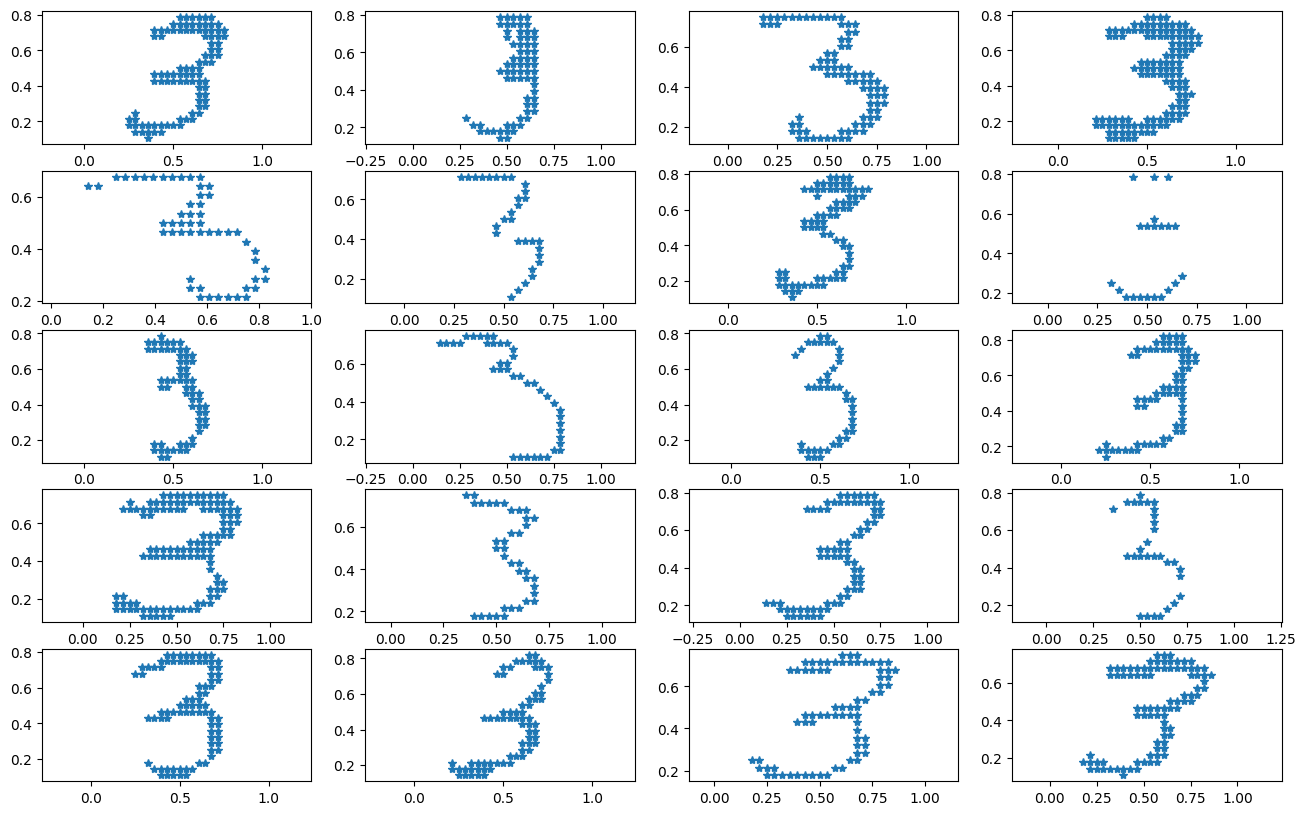

In [30]:
# Question 7

x = torch.load('trois.pt')

for k in range(20):
    plt.subplot(5,4,k+1)
    plt.plot(x[k][:,0],x[k][:,1],"*")
    plt.axis("equal")
plt.show()

In [31]:
# définition des points xbar
xbar = x[5].clone().detach().requires_grad_(True)

# définition du noyau Kv
Kv = GaussKernel(sigma=.25)

# définition du noyau Kw
Kw = GaussKernel(sigma=.1)

# terme d'attache aux données
Dataloss = []
N = 20
for k in range(N):
    loss = lossmeas(x[k], Kw)
    Dataloss.append(loss)

# fonction globale à minimiser
loss = AtlasLDDMMloss(Kv,Dataloss, gamma=0.1)

# initialisation des vecteurs moments p0
p0 = []
for k in range(N):
    p0.append(torch.zeros(xbar.shape, requires_grad=True))

# optimisation de p0 et xbar
res = Optimize(loss,[*p0,xbar],niter=10)
p0 = res[:-1]
xbar = res[-1]

performing optimization...
iteration  1 / 10
iteration  2 / 10
iteration  3 / 10
iteration  4 / 10
iteration  5 / 10
iteration  6 / 10
iteration  7 / 10
iteration  8 / 10
iteration  9 / 10
iteration  10 / 10
Done.


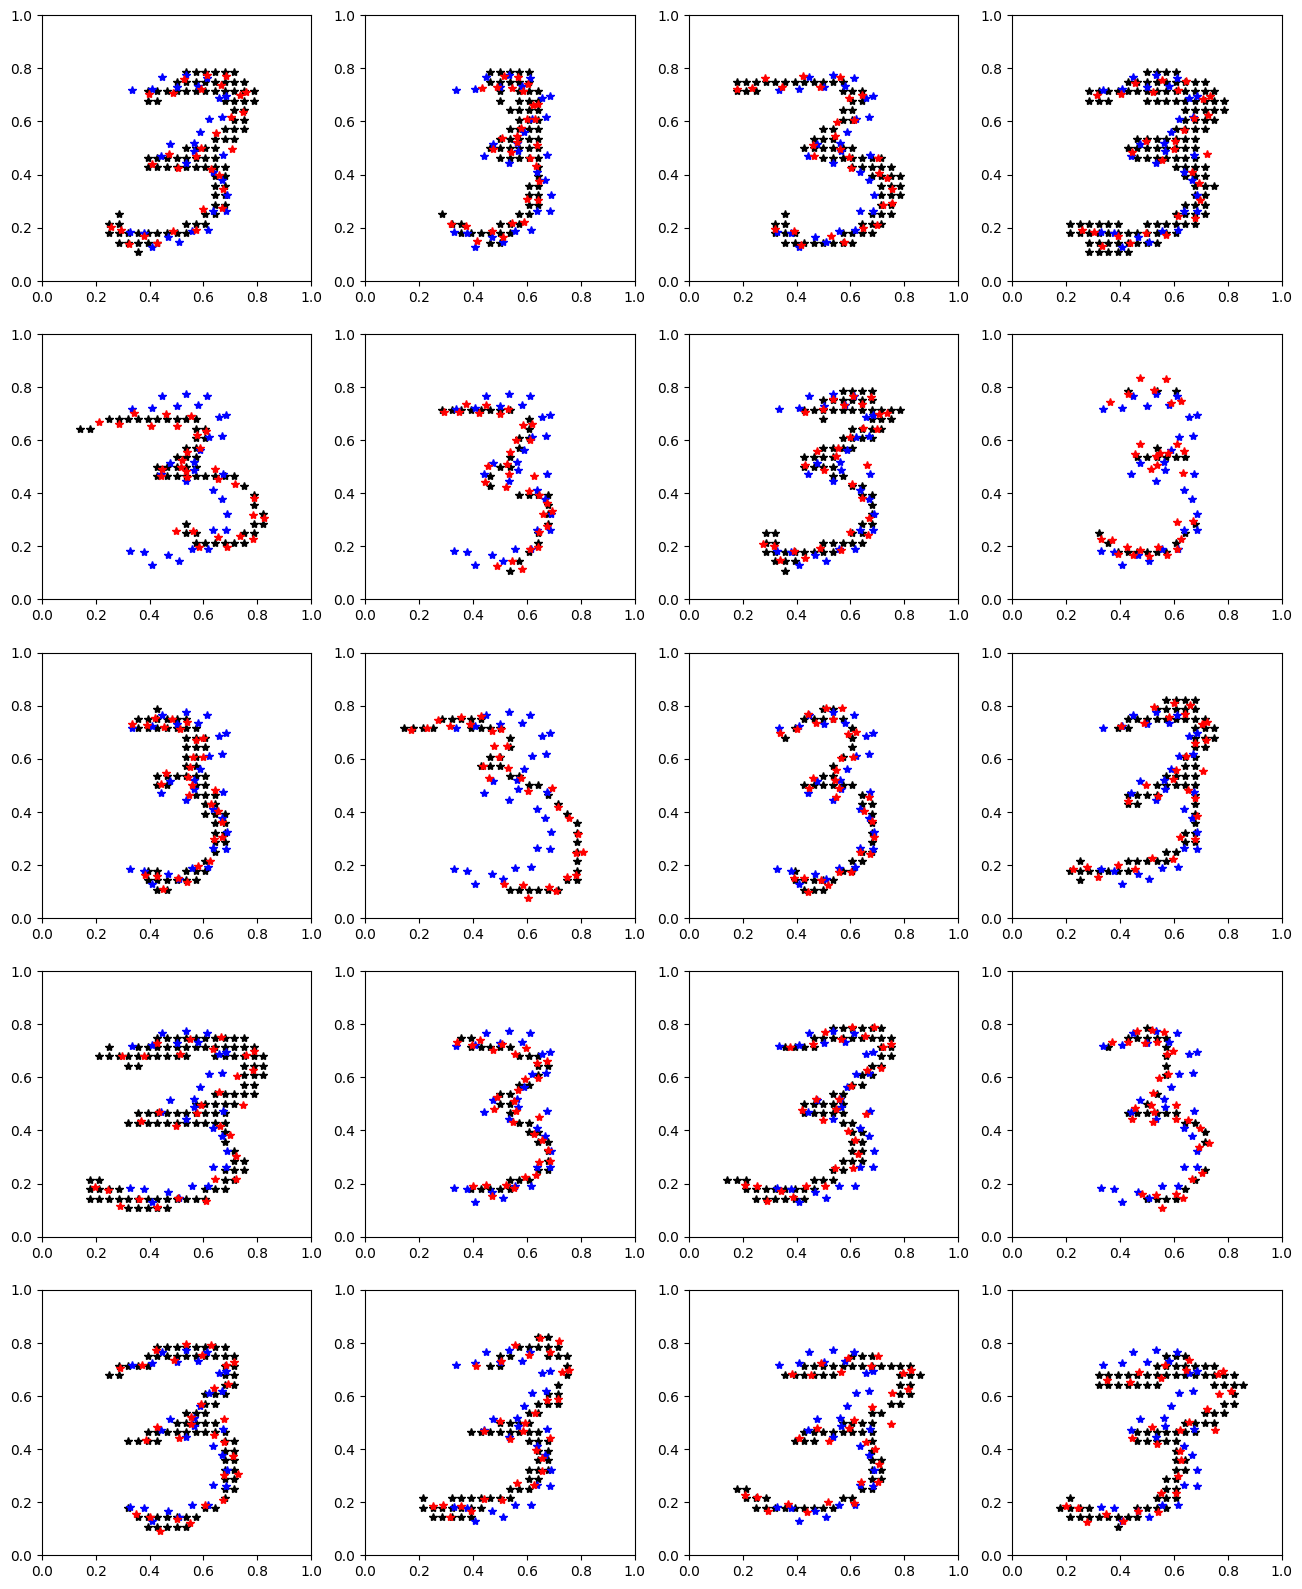

In [32]:
N = len(x) # N=20
plt.figure(figsize=(16,20))
for k in range(N):
    plt.subplot(5,4,k+1)
    plt.plot(x[k][:,0],x[k][:,1],"k*")
    plt.plot(xbar.detach()[:,0],xbar.detach()[:,1],"b*")
    p,q = Shooting(p0[k],xbar,Kv)
    plt.plot(q.detach()[:,0],q.detach()[:,1],"r*")
    plt.axis([0,1,0,1])
plt.show()